In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import calendar
import seaborn as sns
from matplotlib.colors import LogNorm
import geopandas as gpd
import pandas as pd
from pysal.lib import weights
from pysal.explore import esda
import numpy as np

c:\ESSAI\2eme\PFA\Spatiotemporal Disease Outbreak Forecasting\.venv\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\ESSAI\2eme\PFA\Spatiotemporal Disease Outbreak Forecasting\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the datasets
def load_data():
    train_df = pd.read_csv('../data/raw/Train.csv')
    waste_df = pd.read_csv('../data/raw/waste_management.csv')
    toilets_df = pd.read_csv('../data/raw/toilets.csv')
    water_df = pd.read_csv('../data/raw/water_sources.csv')
    return train_df, waste_df, toilets_df, water_df

train_df, waste_df, toilets_df, water_df = load_data()

In [3]:
# 1. Initial Data Exploration for Train Dataset
def explore_train_data(df):
    print("Train Dataset Shape:", df.shape)
    print("\nFirst few rows of the dataset:")
    print(df.head())
    print("\nData Info:")
    print(df.info())
    print("\nSummary Statistics:")
    print(df.describe())
    print("\nMissing Values:")
    print(df.isnull().sum())
    
    # Count unique values in categorical columns
    categorical_cols = ['Location', 'Category_Health_Facility_UUID', 'Disease']
    print("\nUnique Values in Categorical Columns:")
    for col in categorical_cols:
        print(f"\n{col}:")
        print(df[col].value_counts().head())


In [4]:
# Run all analyses
print("Running initial data exploration...")
explore_train_data(train_df)


Running initial data exploration...
Train Dataset Shape: (23848, 9)

First few rows of the dataset:
                                                  ID  Total  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   
4  ID_3a11929e-3317-476d-99f7-1bd9fb58f018_12_202...    0.0   

                                  Location  \
0  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
1  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
2  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
3  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   
4  ID_3a11929e-3317-476d-99f7-1bd9fb58f018   

          Category_Health_Facility_UUID    Disease  Month  Year  \
0  a9280aca-c872-46f5-ada7-4a7cc31cf6ec  Dysentery     12  2022   
1  a9280aca-c872-46f5-ada7-4a7cc31cf6ec    Typhoid     12  2022   
2  a9280aca-c872-46f5-ada7-4a7cc31cf6ec   D

In [5]:
def analyze_time_series(df):
    # Convert Year-Month to datetime for proper sorting
    df['Year-Month'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
    
    # 1. All time monthly outbreaks (2019-2022)
    plt.figure(figsize=(15, 6))
    monthly_outbreaks = df.groupby('Year-Month')['Total'].sum()
    plt.plot(monthly_outbreaks.index, monthly_outbreaks.values, 
            marker='o', linewidth=2, markersize=8)
    
    # Formatting x-axis to show all months
    plt.xticks(monthly_outbreaks.index, 
               [d.strftime('%b-%Y') for d in monthly_outbreaks.index],
               rotation=45, ha='right')
    plt.title('Total Monthly Outbreaks (2019-2022)', fontsize=14)
    plt.xlabel('Month-Year', fontsize=12)
    plt.ylabel('Total Number of Outbreaks', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Monthly outbreaks by year for each disease
    diseases = df['Disease'].unique()
    years = df['Year'].unique()
    
    # Create a figure with subplots for each disease
    fig, axes = plt.subplots(len(diseases), 1, figsize=(15, 5*len(diseases)))
    fig.suptitle('Monthly Outbreaks by Year for Each Disease', fontsize=16, y=1.02)
    
    for idx, disease in enumerate(diseases):
        disease_data = df[df['Disease'] == disease]
        yearly_monthly = disease_data.pivot_table(
            index='Month',
            columns='Year',
            values='Total',
            aggfunc='sum'
        )
        
        yearly_monthly.plot(marker='o', ax=axes[idx])
        axes[idx].set_xticks(range(1, 13))
        axes[idx].set_xticklabels(calendar.month_abbr[1:], rotation=0)
        axes[idx].set_title(f'{disease}', fontsize=12)
        axes[idx].set_xlabel('Month', fontsize=10)
        axes[idx].set_ylabel('Number of Outbreaks', fontsize=10)
        axes[idx].legend(title='Year')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # 3. Total outbreaks by disease type (all time)
    plt.figure(figsize=(12, 6))
    disease_totals = df.groupby('Disease')['Total'].sum().sort_values(ascending=True)
    
    # Create bar plot
    bars = plt.barh(range(len(disease_totals)), disease_totals.values)
    plt.yticks(range(len(disease_totals)), disease_totals.index)
    
    # Add value labels on the bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, i, f' {int(width):,}', 
                va='center', fontsize=10)
    
    plt.title('Total Number of Outbreaks by Disease Type (2019-2022)', fontsize=14)
    plt.xlabel('Total Number of Outbreaks', fontsize=12)
    plt.ylabel('Disease Type', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Additional: Monthly average outbreaks by disease type
    plt.figure(figsize=(15, 6))
    monthly_disease_avg = df.pivot_table(
        index='Year-Month',
        columns='Disease',
        values='Total',
        aggfunc='sum'
    )
    
    plt.plot(monthly_disease_avg.index, monthly_disease_avg.values, marker='o', linestyle='-')
    plt.xticks(monthly_disease_avg.index, 
               [d.strftime('%b-%Y') for d in monthly_disease_avg.index],
               rotation=45, ha='right')
    plt.title('Monthly Outbreaks by Disease Type (2019-2022)', fontsize=14)
    plt.xlabel('Month-Year', fontsize=12)
    plt.ylabel('Number of Outbreaks', fontsize=12)
    plt.legend(monthly_disease_avg.columns, title='Disease Type', 
              bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Analyzing temporal patterns...


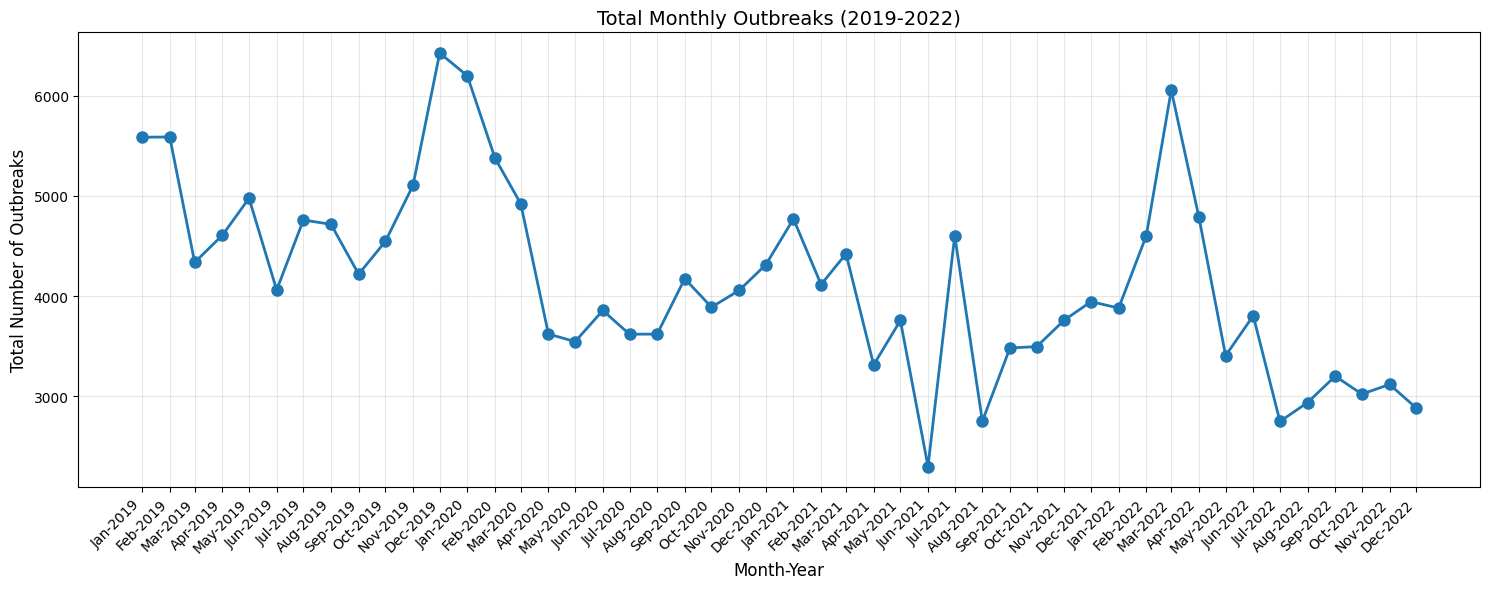

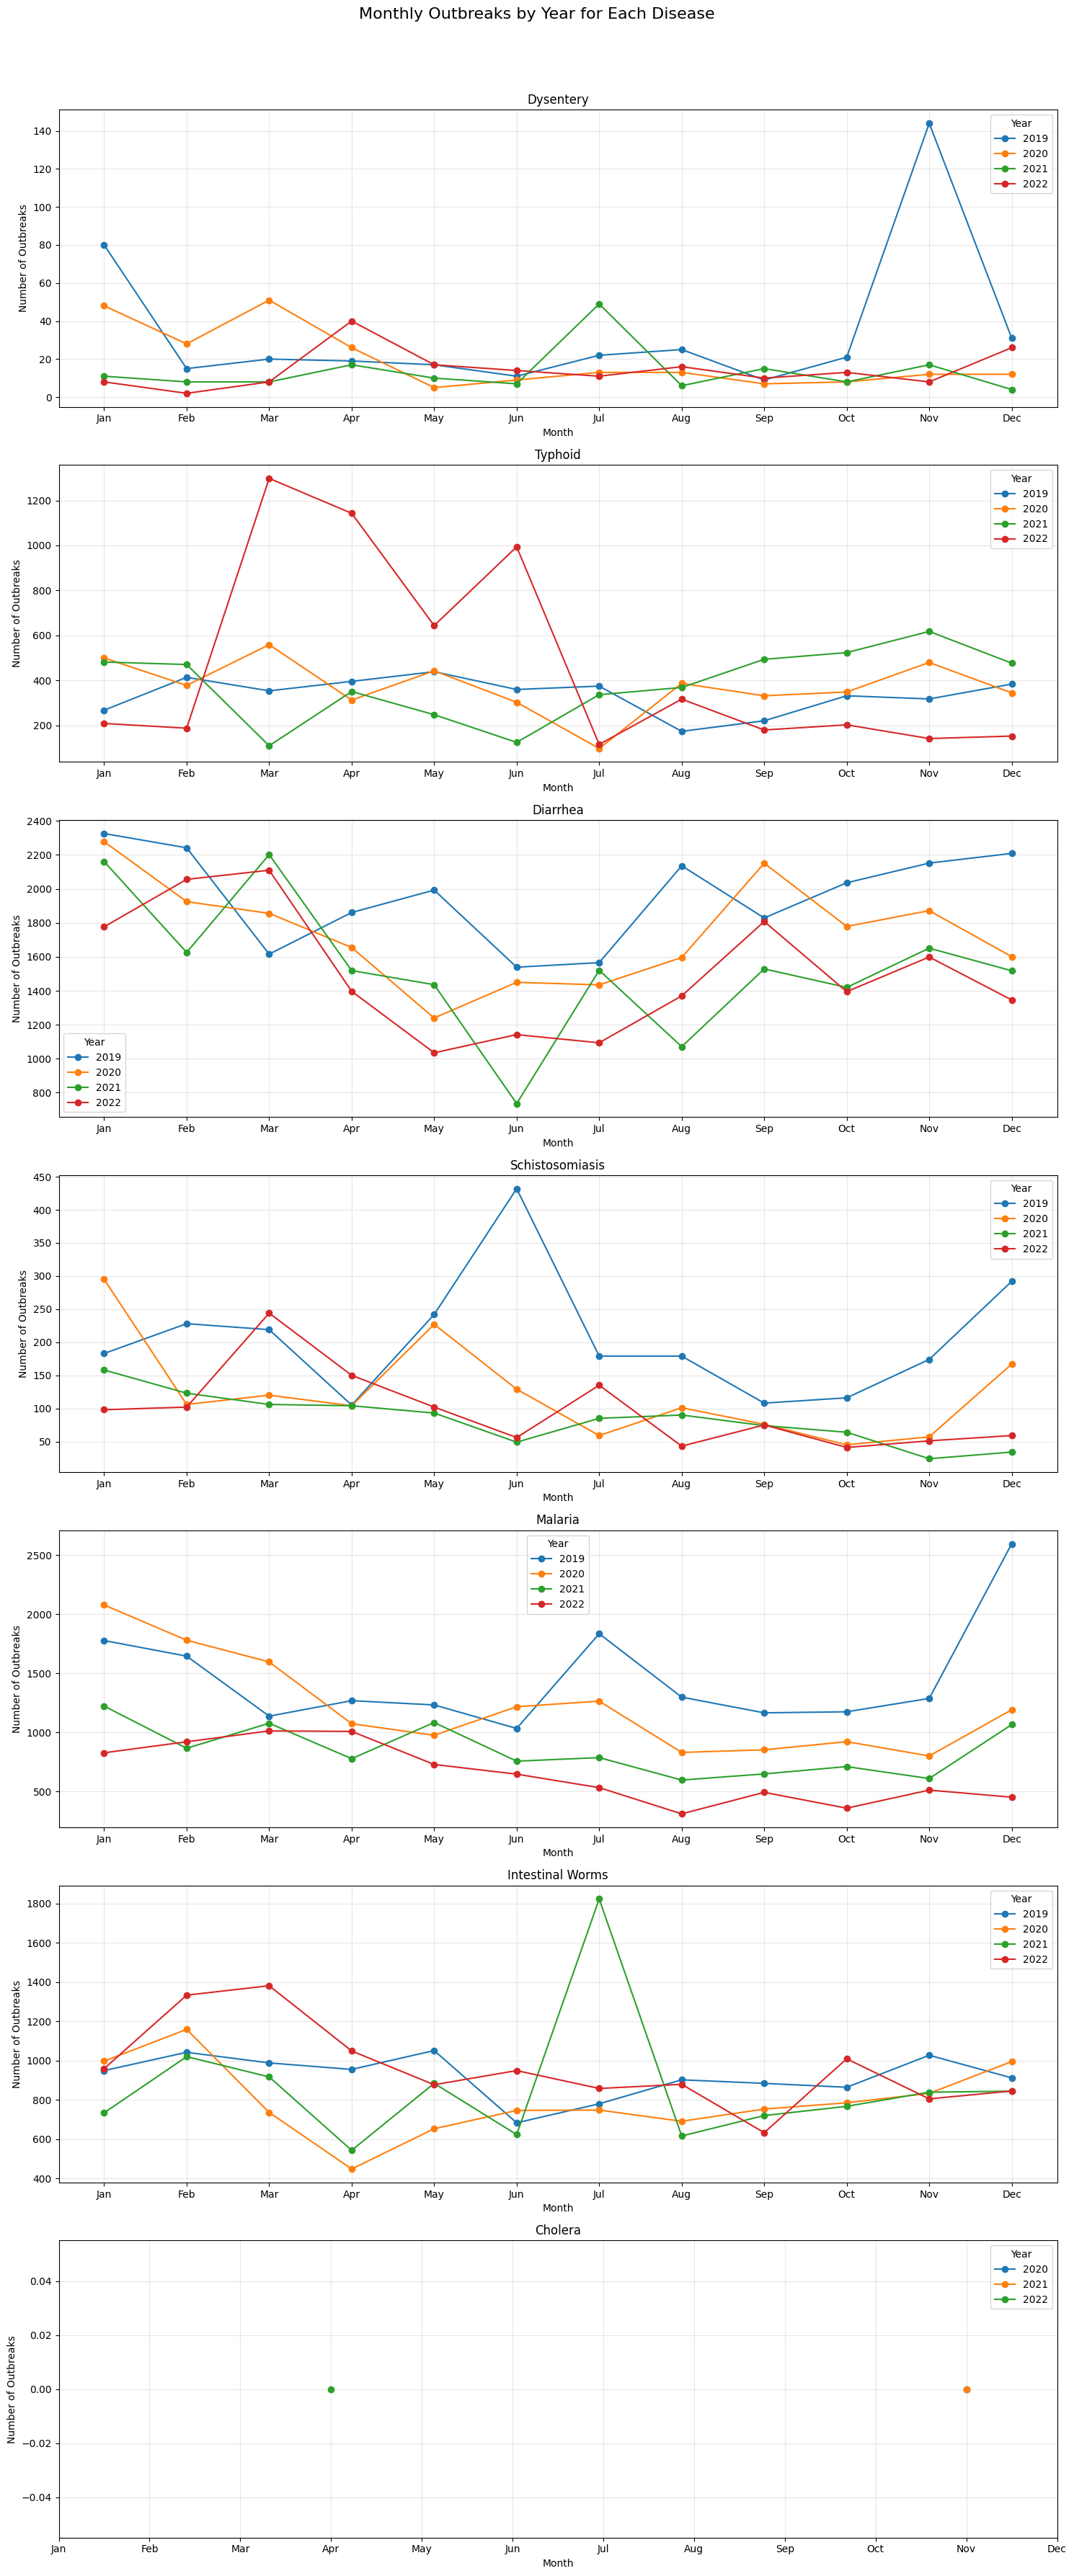

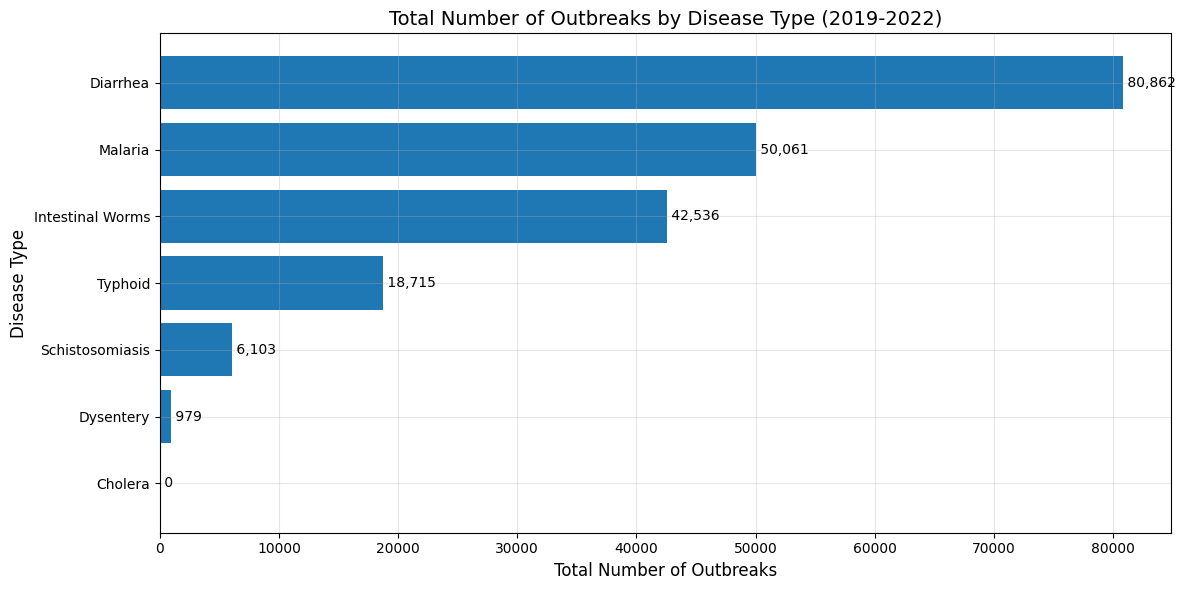

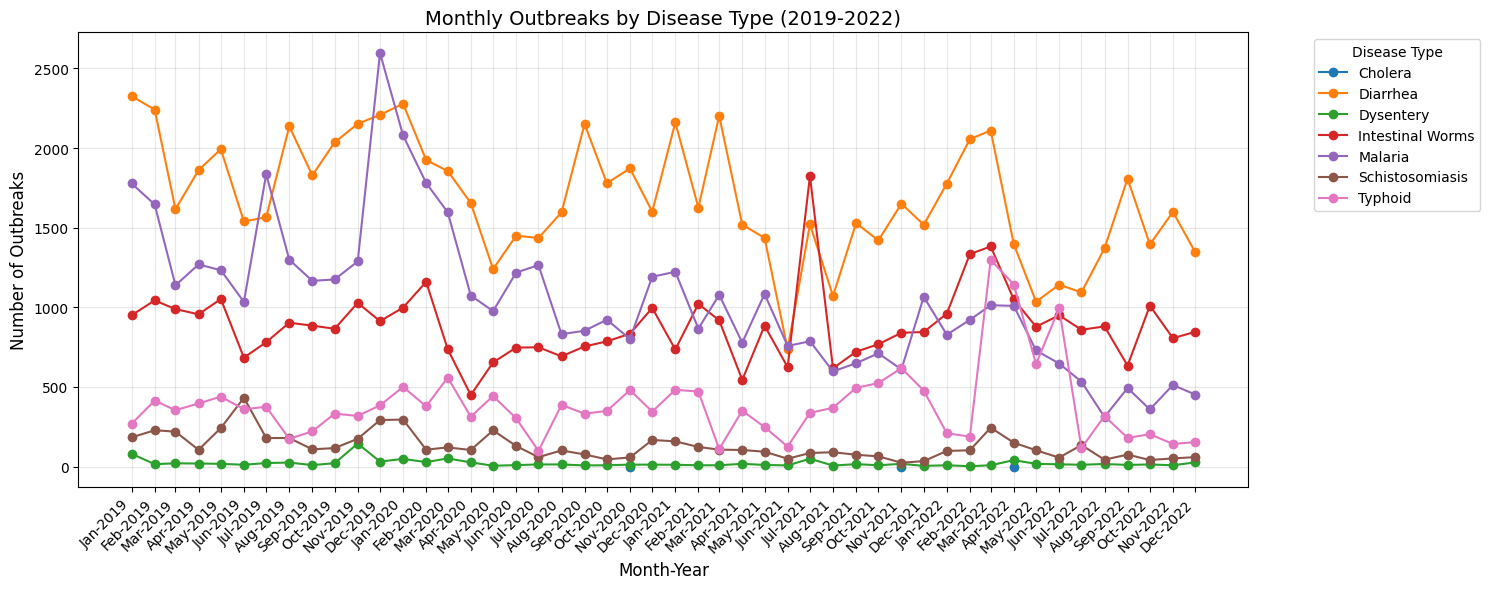

In [6]:
print("\nAnalyzing temporal patterns...")
analyze_time_series(train_df)


# Total Monthly Outbreaks (2019-2022):
- The graph shows significant fluctuations in disease outbreaks over time
- Notable peaks occur around:
    - Early 2020 (around 6,500 cases)
    - Mid-2022 (about 6,000 cases)
- There's a general downward trend from late 2022
- Lowest points appear in mid-2021 (around 2,500 cases)


# Total Number of Outbreaks by Disease Type (2019-2022) :


- Diarrhea is the most prevalent with 80,862 cases
- Malaria is second with 50,061 cases
- Intestinal Worms third with 42,536 cases
- Cholera shows zero cases during this period
- Dysentery has the lowest number among active diseases (979 cases)

# Monthly Outbreaks by Disease Type (2019-2022):
- Shows the temporal evolution of each disease
- Diarrhea consistently shows the highest numbers
- Malaria shows significant seasonal variation
- Lower prevalence diseases show more stable patterns
- Some diseases show clear seasonal patterns

In [7]:
def analyze_spatial_patterns(train_df, waste_df, toilets_df, water_df):
    """
    Create spatial analysis plots for all time periods
    """
    # Create a figure with multiple subplots
    plt.figure(figsize=(20, 15))
    gs = GridSpec(2, 2)
    
    # Plot 1: Disease outbreaks scatter plot with better color visibility
    plt.subplot(gs[0, 0])
    max_outbreaks = train_df['Total'].max()
    
    # Using LogNorm for better color distribution
    scatter = plt.scatter(train_df['Transformed_Longitude'], 
                         train_df['Transformed_Latitude'],
                         c=train_df['Total'],
                         cmap='Reds',  # Changed to 'Reds' for better visibility
                         alpha=0.8,    # Increased alpha
                         s=100,        # Size of markers
                         norm=LogNorm(vmin=1, vmax=max_outbreaks))  # Log scale for better color distribution
    
    plt.colorbar(scatter, label='Number of Outbreaks (log scale)')
    plt.title('Disease Outbreak Distribution', fontsize=12)
    plt.xlabel('Transformed Longitude', fontsize=10)
    plt.ylabel('Transformed Latitude', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Facilities density heatmap
    plt.subplot(gs[0, 1])
    plt.hist2d(train_df['Transformed_Longitude'], 
               train_df['Transformed_Latitude'],
               bins=30,
               cmap='Reds',  # Changed to match the scatter plot
               norm=LogNorm())  # Added log normalization here too
    plt.colorbar(label='Density of Facilities (log scale)')
    plt.title('Health Facilities Density', fontsize=12)
    plt.xlabel('Transformed Longitude', fontsize=10)
    plt.ylabel('Transformed Latitude', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_locations(train_df, water_df, waste_df, toilets_df, year=2022, month=1, month_name='January'):
    """
    Visualize locations for a specific year and month
    Note: months/year should be in the given timeframe [2019, 2023]
    """
    if year < 2019 or year > 2023:
        print("Invalid year. Please choose a year between 2019 and 2023.")
        return

    if month < 1 or month > 12:
        print("Invalid month. Please choose a month between 1 and 12.")
        return

    if month_name.capitalize() not in calendar.month_name[1:]:
        print("Invalid month name. Please choose from 'January' to 'December'.")
        return

    plt.figure(figsize=(15, 10))  # Slightly larger figure
    
    # Define subsets with colors and better visibility
    subsets = [
        (train_df.query(f"Year == {year} and Month == {month}"), 
         'Transformed', 'Hospital', 's', '#FF3333'),  # Brighter red
        (water_df.query(f"Month_Year == '{month}_{year}'"), 
         'Transformed', 'Water', 'o', '#9933FF'),     # Brighter purple
        (waste_df.query(f"Month_Year == '{month}_{year}'"), 
         'Transformed', 'Waste', 'x', '#33CC33'),     # Brighter green
        (toilets_df.query(f"Month_Year == '{month}_{year}'"), 
         'Transformed', 'Toilet', '^', '#3399FF')     # Brighter blue
    ]
    
    # Plot each subset with enhanced visibility
    for df, prefix, label, marker, color in subsets:
        plt.scatter(df[f'{prefix}_Longitude'], 
                   df[f'{prefix}_Latitude'], 
                   label=label, 
                   alpha=0.7,     # Slightly increased alpha
                   marker=marker,
                   c=color,
                   s=120,        # Slightly larger markers
                   edgecolors='white',  # White edges for better contrast
                   linewidth=0.5)
    
    plt.title(f'Locations ({month_name.capitalize()} {year})', fontsize=14, pad=20)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend(fontsize=10, markerscale=1.5)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


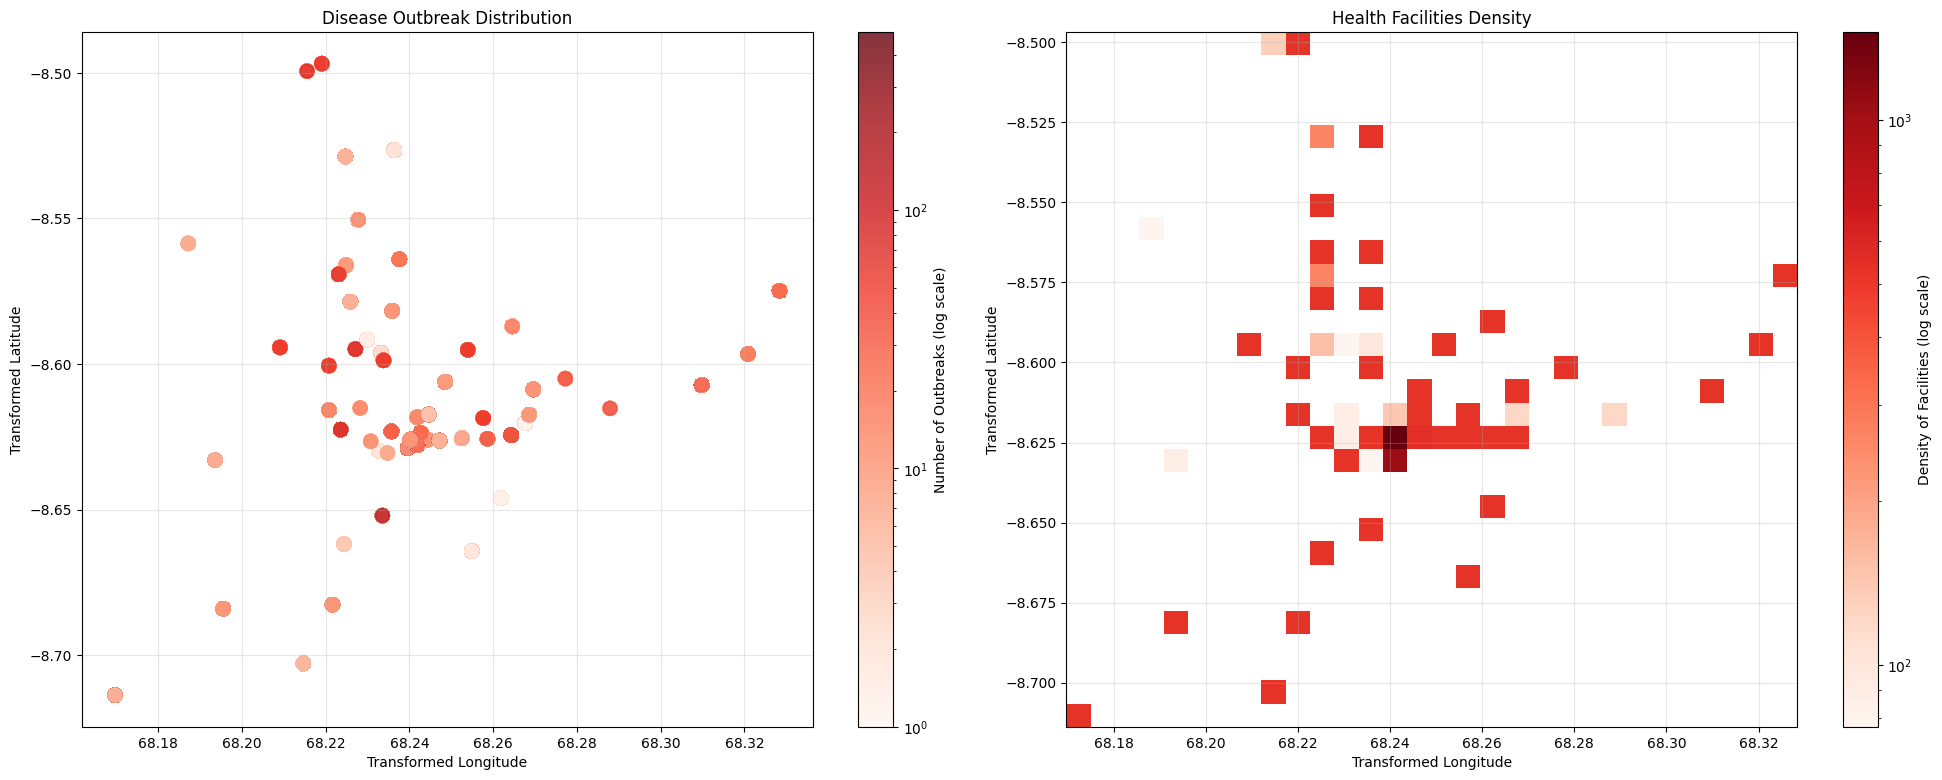

In [8]:
analyze_spatial_patterns(train_df, waste_df, toilets_df, water_df)

# Spatial Analysis:


- Left plot shows disease outbreak distribution by location
- Right plot shows health facility density
- There's clustering of facilities in certain areas
- Disease outbreaks appear to correlate with facility density

In [9]:
def analyze_disease_patterns(df):
    """
    This function creates two visualizations to analyze disease patterns:
    1. A boxplot showing the distribution of outbreaks for each disease
    2. A heatmap showing average outbreaks by disease across time
    """

    # Part 1: Boxplot Analysis
    plt.figure(figsize=(12, 6))  # Create a figure of size 12x6 inches
    sns.boxplot(x='Disease', y='Total', data=df)
    """
    This creates a boxplot that shows:
    - Median number of outbreaks (horizontal line in box)
    - Interquartile range (IQR) (the box)
    - Whiskers (typically 1.5 * IQR)
    - Outliers (points beyond whiskers)
    for each disease type
    """
    plt.title('Distribution of Outbreaks by Disease Type', fontsize=14)
    plt.xticks(rotation=45)  # Rotate disease names 45 degrees for better readability
    plt.xlabel('Disease Type', fontsize=12)
    plt.ylabel('Number of Outbreaks', fontsize=12)
    plt.show()

    # Part 2: Heatmap Analysis
    # Create a pivot table for the heatmap
    disease_pivot = df.pivot_table(
        index='Disease',          # Rows will be diseases
        columns=['Year', 'Month'], # Columns will be Year-Month combinations
        values='Total',           # Values will be outbreak counts
        aggfunc='mean'           # Calculate average for each combination
    ).fillna(0)                  # Replace any missing values with 0
    
    plt.figure(figsize=(30, 15))  # Create a new figure
    sns.heatmap(disease_pivot, 
                cmap='YlOrRd',    # Yellow to Red color scheme
                annot=True,       # Show numbers in cells
                fmt='.1f',        # Format numbers to 1 decimal place
                cbar_kws={'label': 'Average Number of Outbreaks'})
    """
    The heatmap shows:
    - Each row is a disease type
    - Each column is a specific year-month
    - Color intensity indicates the average number of outbreaks
    - Actual values are shown in each cell
    """
    plt.title('Disease Outbreaks Heatmap (Year-Month)', fontsize=14)
    plt.ylabel('Disease Type', fontsize=12)
    plt.xlabel('Year-Month', fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()

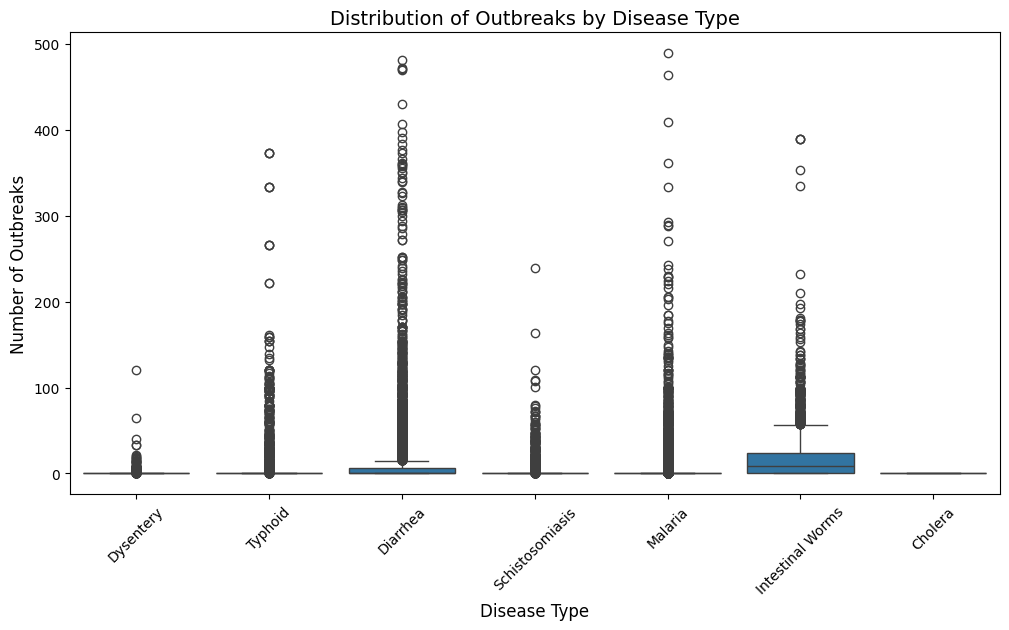

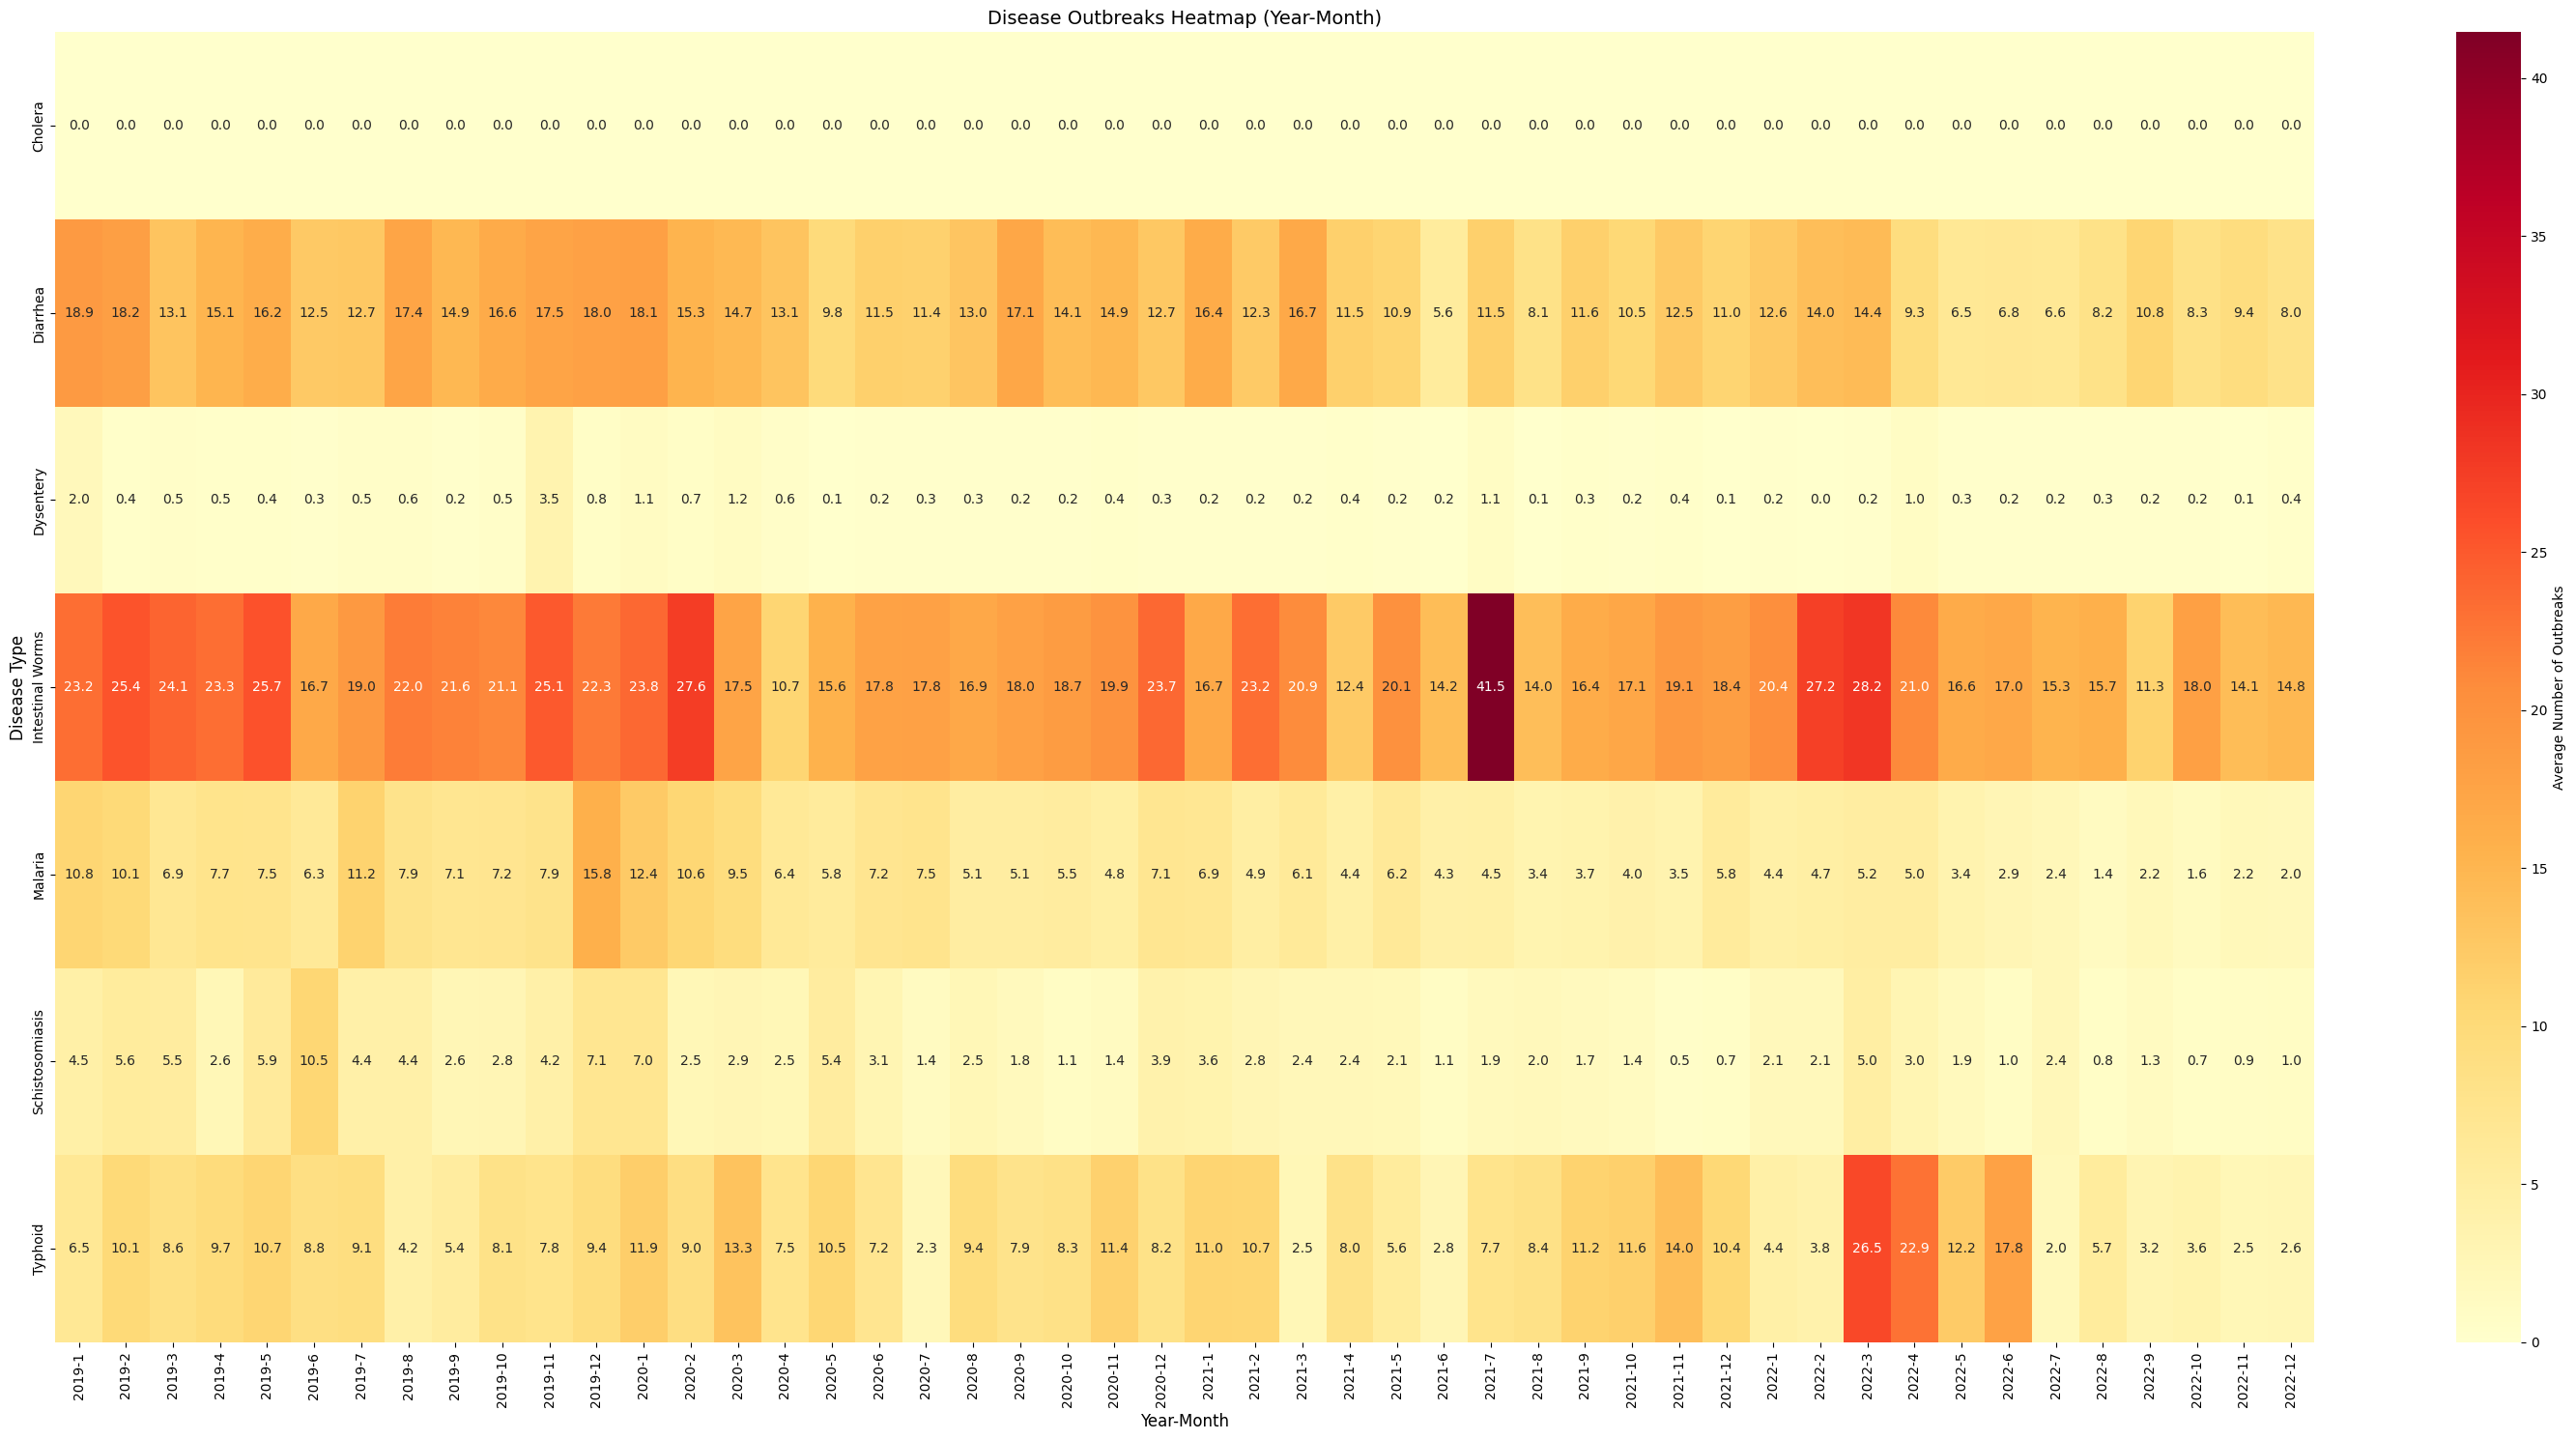

In [10]:
analyze_disease_patterns(train_df)

In [11]:
def analyze_climate_patterns(waste_df):
    """
    Analyze climate variable patterns in the dataset
    """
    # Select relevant climate variables
    climate_vars = ['2t', '2d', 'tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4', '10u', '10v']
    
    # Map for meaningful names
    climate_var_names = {
        '2t': 'Temperature (C)',
        '2d': 'Dew Point (C)',
        'tp': 'Total Precipitation (mm)',
        'swvl1': 'Volumetric Soil Water Layer 1 (m3/m3)',
        'swvl2': 'Volumetric Soil Water Layer 2 (m3/m3)',
        'swvl3': 'Volumetric Soil Water Layer 3 (m3/m3)',
        'swvl4': 'Volumetric Soil Water Layer 4 (m3/m3)',
        '10u': '10m U Wind Component (m/s)',
        '10v': '10m V Wind Component (m/s)'
    }
    
    # Convert temperature from Kelvin to Celsius
    waste_df['2t'] = waste_df['2t'] - 273.15
    waste_df['2d'] = waste_df['2d'] - 273.15
    
    # Separate climate variables into different groups based on their ranges
    high_range_vars = ['2t', '2d']  # Typically higher values (e.g., temperature)
    low_range_vars = ['tp', 'swvl1', 'swvl2', 'swvl3', 'swvl4', '10u', '10v']  # Typically lower values
    
    # Plot high range variables
    plt.figure(figsize=(15, 6))
    high_range_monthly = waste_df.groupby('Month')[high_range_vars].mean()
    high_range_monthly.columns = [climate_var_names[var] for var in high_range_vars]  # Rename columns
    high_range_monthly.plot(marker='o')
    plt.xticks(range(12), calendar.month_abbr[1:], rotation=0)
    plt.title('Monthly Average High Range Climate Variables', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Plot low range variables
    plt.figure(figsize=(15, 6))
    low_range_monthly = waste_df.groupby('Month')[low_range_vars].mean()
    low_range_monthly.columns = [climate_var_names[var] for var in low_range_vars]  # Rename columns
    low_range_monthly.plot(marker='o')
    plt.xticks(range(12), calendar.month_abbr[1:], rotation=0)
    plt.title('Monthly Average Low Range Climate Variables', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    climate_corr = waste_df[climate_vars].corr()
    climate_corr.columns = [climate_var_names[var] for var in climate_vars]  # Rename columns
    climate_corr.index = [climate_var_names[var] for var in climate_vars]    # Rename index
    sns.heatmap(climate_corr, 
                annot=True, 
                cmap='coolwarm',
                fmt='.2f')
    plt.title('Correlation Between Climate Variables', fontsize=14)
    plt.tight_layout()
    plt.show()


Analyzing climate patterns...


<Figure size 1500x600 with 0 Axes>

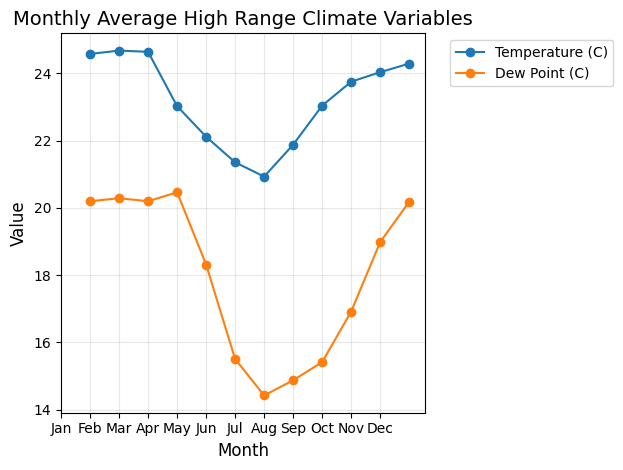

<Figure size 1500x600 with 0 Axes>

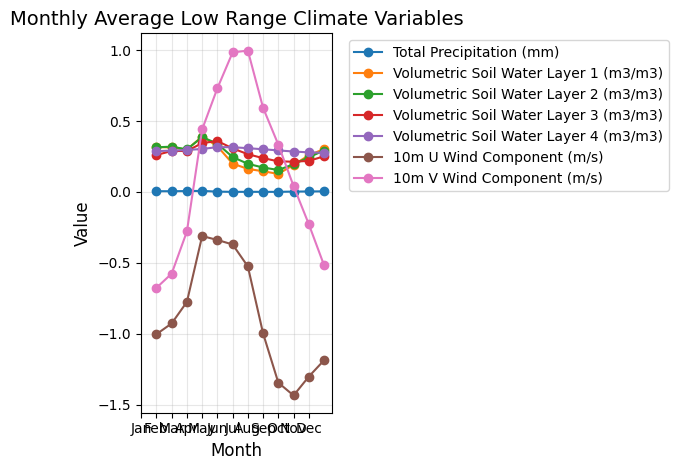

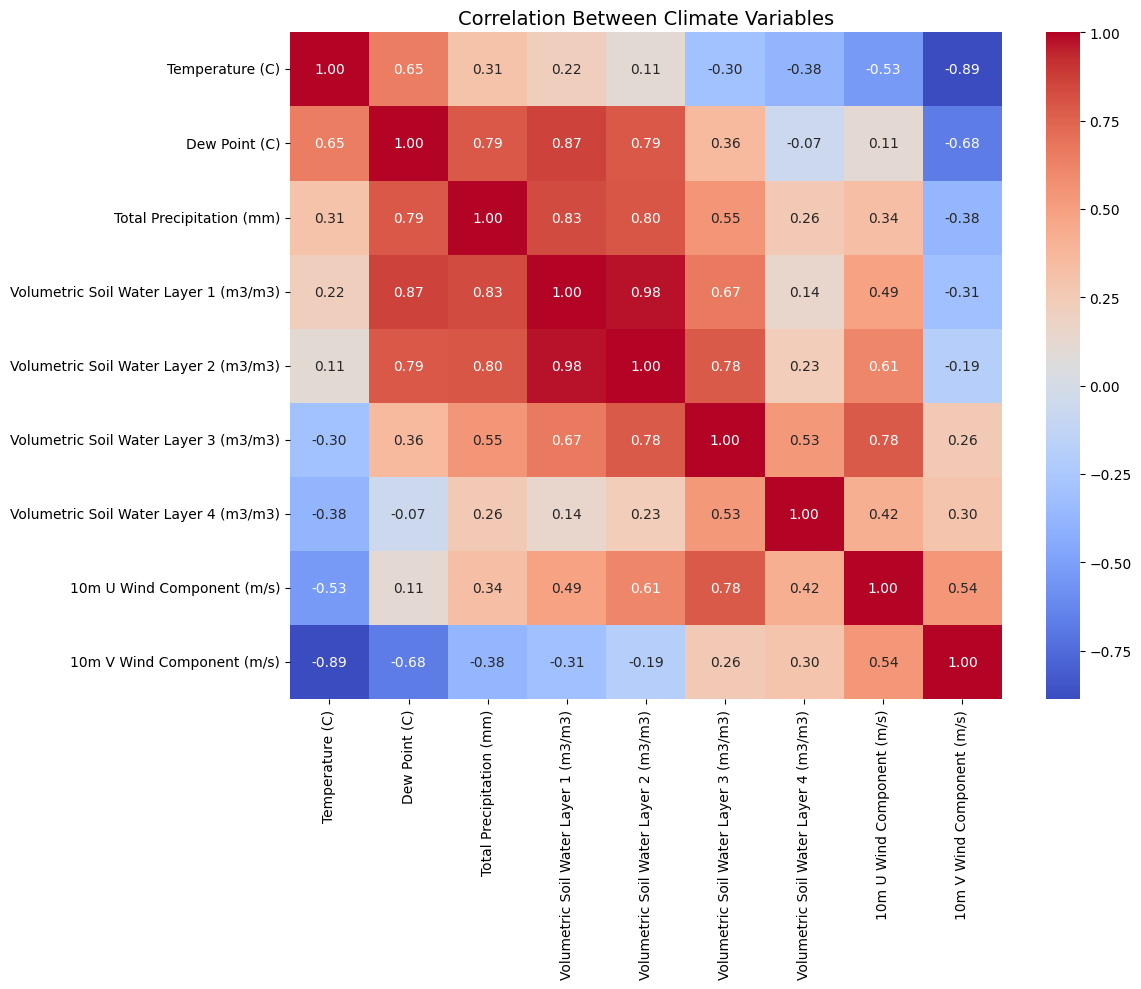

In [12]:
print("\nAnalyzing climate patterns...")
analyze_climate_patterns(waste_df)

C:\Users\meddh\AppData\Local\Temp\ipykernel_18560\1202116389.py:23: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Date_left', 'Year_left', 'Transformed_Latitude_left', 'Month_left', 'Transformed_Longitude_left'} in the result is deprecated and will raise a MergeError in a future version.
  merged_gdf = gpd.sjoin(merged_gdf, water_gdf, how='left', predicate='intersects')
C:\Users\meddh\AppData\Local\Temp\ipykernel_18560\1202116389.py:47: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = weights.Queen.from_dataframe(df)


Moran's I: nan
Geary's C: nan


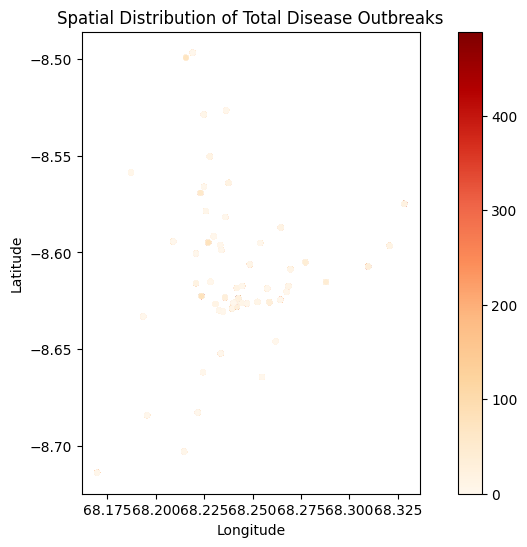

In [20]:
# Convert dates to datetime
train_df['Date'] = pd.to_datetime(train_df[['Year', 'Month']].assign(DAY=1))
waste_df['Date'] = pd.to_datetime(waste_df[['Year', 'Month']].assign(DAY=1))
toilets_df['Date'] = pd.to_datetime(toilets_df[['Year', 'Month']].assign(DAY=1))
water_df['Date'] = pd.to_datetime(water_df[['Year', 'Month']].assign(DAY=1))

# Create GeoDataFrames for spatial operations
train_gdf = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.Transformed_Longitude, train_df.Transformed_Latitude))
waste_gdf = gpd.GeoDataFrame(waste_df, geometry=gpd.points_from_xy(waste_df.Transformed_Longitude, waste_df.Transformed_Latitude))
toilets_gdf = gpd.GeoDataFrame(toilets_df, geometry=gpd.points_from_xy(toilets_df.Transformed_Longitude, toilets_df.Transformed_Latitude))
water_gdf = gpd.GeoDataFrame(water_df, geometry=gpd.points_from_xy(water_df.Transformed_Longitude, water_df.Transformed_Latitude))

# Merge datasets based on spatial and temporal keys
# Perform the first spatial join
merged_gdf = gpd.sjoin(train_gdf, waste_gdf, how='left', predicate='intersects')
merged_gdf = merged_gdf.drop(columns=['index_right'])

# Perform the second spatial join
merged_gdf = gpd.sjoin(merged_gdf, toilets_gdf, how='left', predicate='intersects')
merged_gdf = merged_gdf.drop(columns=['index_right'])

# Perform the third spatial join
merged_gdf = gpd.sjoin(merged_gdf, water_gdf, how='left', predicate='intersects')
merged_gdf = merged_gdf.drop(columns=['index_right'])

# Function to calculate Moran's I and Geary's C
def calculate_spatial_autocorrelation(df, value_column):
    """
    Calculate Moran's I and Geary's C for spatial data.
    
    Parameters:
    df (GeoDataFrame): The input GeoDataFrame with spatial data.
    value_column (str): The column name for the values to analyze.
    
    Returns:
    dict: A dictionary with Moran's I and Geary's C values.
    """
    # Ensure the GeoDataFrame has a geometry column
    if 'geometry' not in df.columns:
        raise ValueError("GeoDataFrame must contain a 'geometry' column with spatial data.")
    
    # Ensure the value_column exists
    if value_column not in df.columns:
        raise ValueError(f"Column '{value_column}' not found in GeoDataFrame.")
    
    # Create spatial weights matrix
    w = weights.Queen.from_dataframe(df)
    w.transform = 'r'
    
    # Extract the values
    values = df[value_column].values
    
    # Calculate Moran's I
    moran = esda.Moran(values, w)
    moran_i = moran.I
    
    # Calculate Geary's C
    geary = esda.Geary(values, w)
    geary_c = geary.C
    
    return {'Moran\'s I': moran_i, 'Geary\'s C': geary_c}

# Example usage
# Load your GeoDataFrame (ensure it has 'geometry' and the value column)
value_column = 'Total'

# Calculate Moran's I and Geary's C
results = calculate_spatial_autocorrelation(merged_gdf, value_column)
print("Moran's I:", results["Moran's I"])
print("Geary's C:", results["Geary's C"])

# Plot spatial distribution of 'Total' variable
merged_gdf.plot(column=value_column, legend=True, figsize=(10, 6), cmap='OrRd', markersize=10)
plt.title('Spatial Distribution of Total Disease Outbreaks')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [24]:
# Check if 'Total' column has valid values
print(merged_gdf['Total'].describe())

# Check if there are NaNs
print("NaN values:", merged_gdf['Total'].isna().sum())

# Check if there are unique values
print("Unique values:", merged_gdf['Total'].nunique())

# Check if geometry is missing
print("Missing geometries:", merged_gdf.geometry.isna().sum())
print("Empty geometries:", merged_gdf.geometry.is_empty.sum())

# Try using kNN weights instead of Queen
from libpysal import weights
w = weights.KNN.from_dataframe(merged_gdf, k=57)
w.transform = 'r'

# Recalculate Moran's I and Geary's C
from esda import Moran, Geary
values = merged_gdf['Total'].fillna(0).values

moran = Moran(values, w)
geary = Geary(values, w)

print("Fixed Moran's I:", moran.I)
print("Fixed Geary's C:", geary.C)


count    23847.000000
mean         8.355600
std         28.076713
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max        489.000000
Name: Total, dtype: float64
NaN values: 1
Unique values: 260
Missing geometries: 0
Empty geometries: 0


c:\ESSAI\2eme\PFA\Spatiotemporal Disease Outbreak Forecasting\.venv\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 56 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


Fixed Moran's I: 0.11537708095050608
Fixed Geary's C: 0.9504079369006821


Exception: one or more input arrays have missing/NaN values

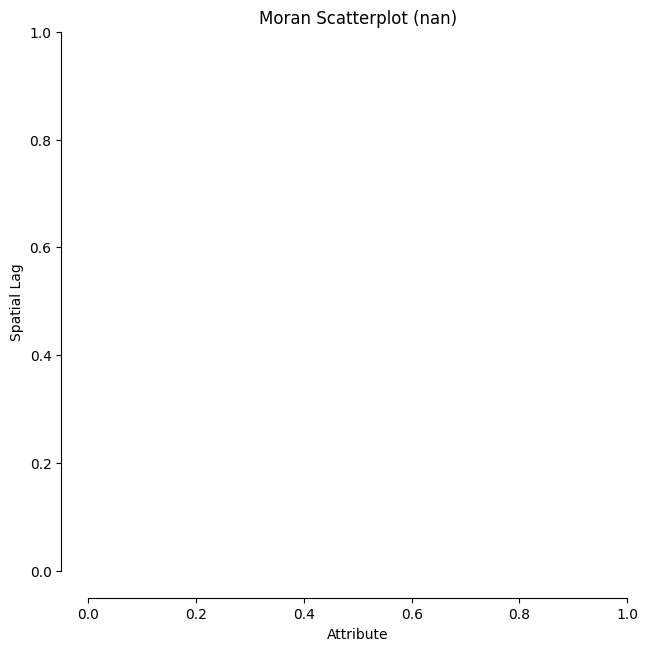

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from splot.esda import moran_scatterplot
from esda import Moran

# Recalculate Moran's I
moran = Moran(merged_gdf['Total'].values, w)

# Plot Moran's I Scatterplot
fig, ax = moran_scatterplot(moran)
plt.title("Moran's I Scatterplot - Disease Outbreaks")
plt.show()
